# Setup
## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl

In [2]:
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec

In [3]:
# contains helper functions to do actual optimizaiton analysis
import optimization_helper_functions as OHF

In [4]:
cwd = os.getcwd()

## Figure Formatting

In [5]:
mpl.rcParams['lines.linewidth'] = 3    # change the default line thickness for plots to 4
mpl.rcParams['lines.markersize'] = 2
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}            # change the default font size and type for axes labels and ticks
plt.rc('font', **font)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 400
csfont = {'fontname':'Serif'}
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize'] = 3.25, 2.8

# plt.rcParams['axes.Axes.tick_params.direction'] = 'in'
plt.rcParams['figure.facecolor'] = 'white'

mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9

mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.labelsize']=9

In [6]:
diameter = 1.27 #cm
area = np.pi*(diameter/2)**2
Fconst=96485

molar_mass_LiV3O8 = 287.7607
density_LiV3O8 = 3.15              
density_carbon = 2.266
max_mAhg = 362

ed_col = 'Electrode Volumetric Energy Density (Wh/cm3)'
pd_col = 'Electrode Volumetric Power Density (W/cm3)'
aed_col = 'Electrode Areal Energy Density (Wh/cm2)'
apd_col = 'Electrode Areal Power Density (W/cm2)'
ced_col = 'Cell Volumetric Energy Density (Wh/cm3)'

## Read in simulations data

In [18]:
sims_dict = {'TB':[],'noTB':[]}
drop_cols = ['Bind Loading (g)', 'Cathode Volume (cm3)','Vol Frac Bind','mAh_exp','tstep (s)','Specific Current (mA/g)','Current (A)','Current Density (mA/cm2)','Tortuosity (Bruggeman)']
crates = [0.1,0.2,0.33,0.5,0.75,1]
for tbtb in sims_dict.keys():
    all_crate_sims_that_ran = []
    for cr in crates:
       
        colname_filename = cwd+'/vary_crate/'+str(cr)+'_C/column_names.txt'
        
        if tbtb == 'noTB':
            filename = cwd+'/vary_crate/'+str(cr)+'_C/Simulation_Parameters_processed_noTB.txt'
            all_sims, sims_that_ran, sims_that_crashed = OHF.read_in_sims_table(filename,colname_filename,drop_cols,print_cols=False,no_TB=True)
        else:
            filename = cwd+'/vary_crate/'+str(cr)+'_C/Simulation_Parameters_processed.txt'
            all_sims, sims_that_ran, sims_that_crashed = OHF.read_in_sims_table(filename,colname_filename,drop_cols,print_cols=False)
                
        sims_that_ran[apd_col] = sims_that_ran[pd_col]*sims_that_ran['L (um)']/10000
        all_crate_sims_that_ran.append(sims_that_ran)

    sims_dict[tbtb] = pd.concat(all_crate_sims_that_ran)

# Electrode Conductivity dependence on Vol. Frac. Conductor

In [8]:
vfrac_perc = 0.05
sigma_AM = 1e-5
sigma_MWNT = 1.0

# percolation theory
def conductivity(vfrac_cond):
    s,t = 1,1
    if vfrac_cond<vfrac_perc:
        sigma = sigma_AM*((vfrac_perc-vfrac_cond)/vfrac_perc)**(-1*s)
    else:
        sigma = sigma_MWNT*((vfrac_cond-vfrac_perc)/(1-vfrac_perc))**t        
    return sigma

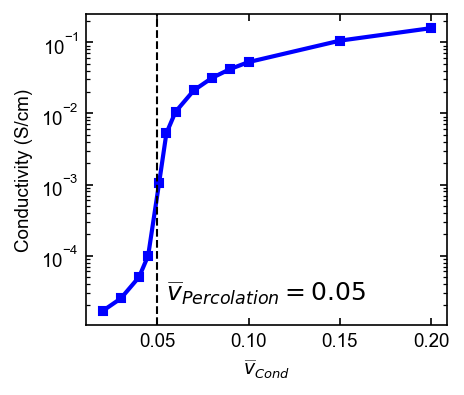

In [9]:
new_cond_list = []
all_sims_that_ran = sims_dict['TB']
fig,ax = plt.subplots()
colors = plt.get_cmap('viridis')(np.linspace(0.3,1,len(all_sims_that_ran['Porosity'].unique())))
vfcs = list(np.linspace(0.02,0.07,10)) + [0.07,0.08,0.09,0.1,0.15,0.2]
vfcs =  [0.02,0.03,0.04,0.045,0.051,0.055,0.06,0.07,0.08,0.09,0.1,0.15,0.2]
for vf_c in vfcs:    
    new_cond_list.append(conductivity(vf_c))
ax.semilogy(vfcs,new_cond_list,'-s',color='blue',lw=2,ms=4)
    
ax.set_xlabel(r'$\widebar{v}_{Cond}$')

ax.set_ylabel('Conductivity (S/cm)')
ax.axvline(x=vfrac_perc,linestyle='--',color='black',lw=1)
ax.text(0.055,0.00003,r'$\widebar{v}_{Percolation} = 0.05$',horizontalalignment='left',verticalalignment='center')
fig.tight_layout()

# Optimization 
## Volumetric and Areal Energy Density

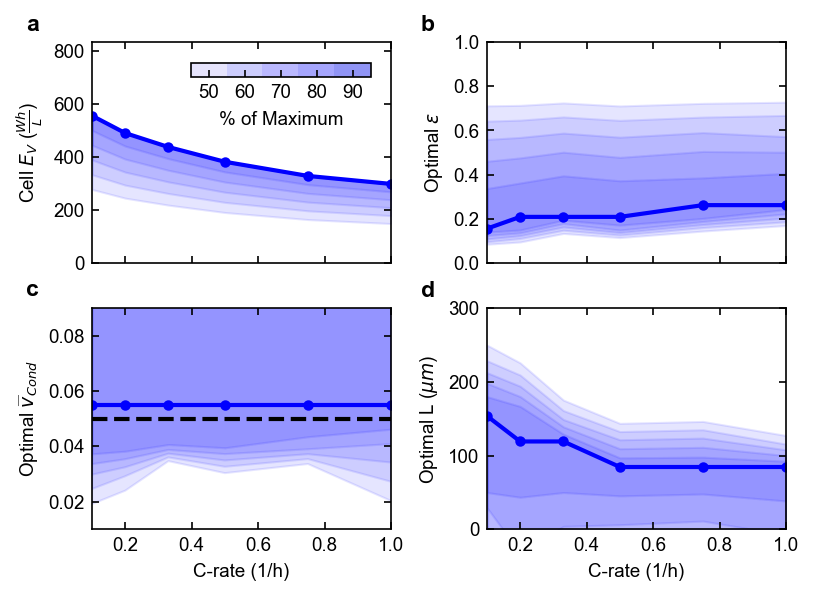

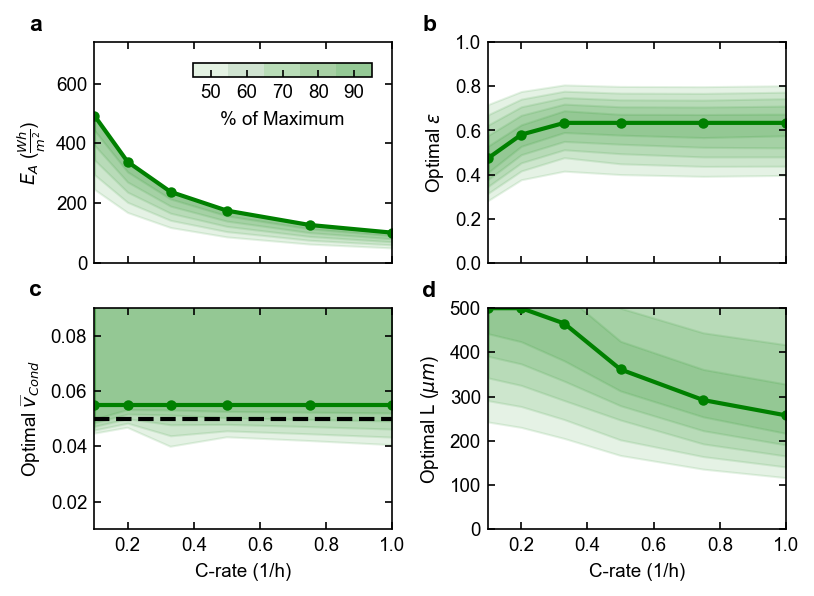

In [10]:
all_sims_that_ran = sims_dict['TB']
best_cols = ['Porosity','Vol Frac Cond','L (um)']
design_parameters = ['Cell Energy Density (Wh/cm3)',aed_col]
output_labels = [r'Cell $E_V$ ($\frac{Wh}{L}$)',r'$E_A$ ($\frac{Wh}{m^2}$)']
cmaps = [mpl.colors.ListedColormap(['#E6E4FC','#CCCDFD','#BAB8FF','#A5A5FD','#9094F5']),mpl.colors.ListedColormap(['#E4F2E3','#CFE3D0','#B9DDB8','#A7D0A4','#94C995'])]
colors = ['blue','green']

Lubs = [300,500]

fig3,ax3 = plt.subplots(2,2,figsize = (5.5,4),sharex='col', sharey=False)
fig4,ax4 = plt.subplots(2,2,figsize = (5.5,4),sharex='col', sharey=False)

all_sims_that_ran = sims_dict['TB']
all_sims_that_ran = OHF.add_cell_ED_v2(all_sims_that_ran)

for i,(design_parameter,figi,axi) in enumerate(zip(design_parameters,[fig3,fig4],[ax3,ax4])):
    all_sims_that_ran,new_design_parameter = OHF.change_units(all_sims_that_ran,design_parameter)
    
    best_df = OHF.design_guide_plots(all_sims_that_ran,[new_design_parameter]+best_cols+['AM areal loading (mg/cm2)'],[axi[0,0],axi[0,1],axi[1,0],axi[1,1]],optimize_output=new_design_parameter,color=colors[i])
    for pp in [0.9,0.8,0.7,0.6,0.5]:
        OHF.plot_percentile(all_sims_that_ran,best_cols,[axi[0,1],axi[1,0],axi[1,1]],color=colors[i],percentile=pp,optimize_output=new_design_parameter)
        axi[0,0].fill_between(crates,best_df[new_design_parameter],(pp)*best_df[new_design_parameter],color=colors[i],label=None,alpha=0.1)
    
    axi[0,0].set_xlabel('')
    axi[0,0].set_ylabel(output_labels[i])#,color=colors[i])
    axi[0,0].set_ylim(0,best_df.loc[0,new_design_parameter]*1.5)
    
    axi[0,1].set_ylim(0,1)
    axi[0,1].set_ylabel(r'Optimal $\epsilon$')
    axi[0,1].set_xlabel('')
    
    axi[1,0].axhline(y=0.05,linestyle='--',color='black',lw=2,marker='')
    axi[1,0].set_yscale('linear')
    axi[1,0].set_ylim(0.01,0.09)
    axi[1,0].set_ylabel(r'Optimal $\widebar{v}_{Cond}$')
   
    axi[1,1].set_ylim(0,Lubs[i])
    axi[1,1].set_ylabel(r'Optimal L ($\mu m$)')
    

    figi.tight_layout()
    OHF.add_letters_v2(figi.axes[:4],xmult=0.9,ymult=1.05,fontsize=11)
    
    for axicr in figi.axes:
        axicr.set_xlim(0.1,1.0)

    iax = inset_axes(axi[0,0], 
                width="100%", # width = 30% of parent_bbox
                height="40%", # height : 1 inch
                bbox_to_anchor=(0.3, .8, .6, .16),bbox_transform=axi[0,0].transAxes, loc=3)
    OHF.add_colorscale_horizontal(iax,cmaps[i])

## Crystal-scale concentration profiles for optimal electrodes at each C-rate

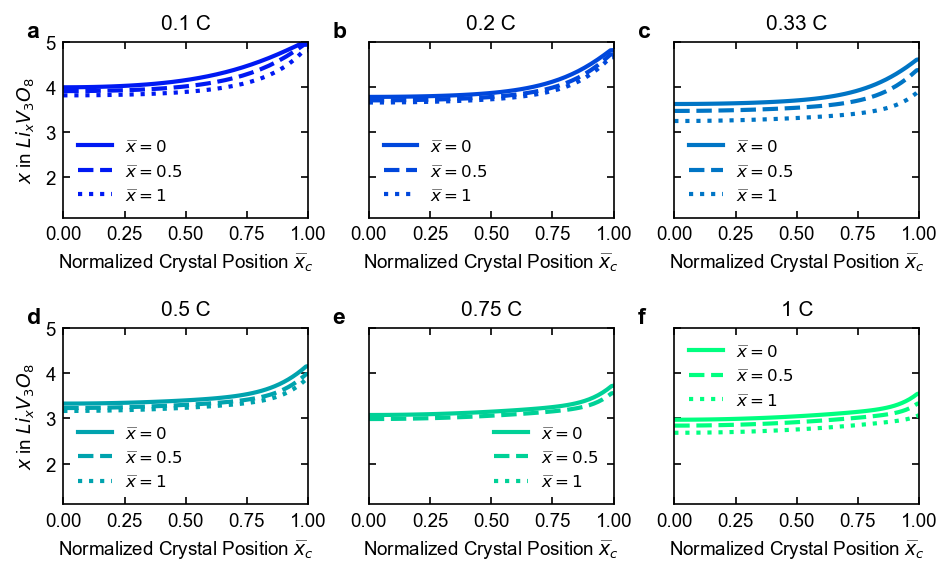

In [11]:
CPTcols = ['State', 'Time', 'Equivalence', 'xx_c(j)', 'J=1', 'c_alpha',
       'Theta_beta', 'c_beta', 'cycle', 'J=NJ/4', 'c_alpha.1', 'Theta_beta.1',
       'c_beta.1', 'cycle.1', 'J=NJ/2', 'c_alpha.2', 'Theta_beta.2',
       'c_beta.2', 'cycle.2', 'J=NJ_3/4', 'c_alpha.3', 'Theta_beta.3',
       'c_beta.3', 'cycle.3', 'J=NJ', 'c_alpha.4', 'Theta_beta.4', 'c_beta.4',
       'cycle.4']
colors = plt.get_cmap('winter')(np.linspace(0.1,1,len(crates)))
linestyles = ['-','--',':']
labels = [r'$\widebar{x} = 0$',r'$\widebar{x} = 0.5$',r'$\widebar{x} = 1$']

fig,ax = plt.subplots(2,3,figsize=(6.5,4),sharey=True)
axs = [ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
for k,cr in enumerate(crates):
    filename = cwd+'/vary_crate/'+str(cr)+'_C/best_sim/Crystal_Conc_Position.txt'
    CPT = pd.read_csv(filename,delim_whitespace=True,names = CPTcols)
    
    for i,loc in enumerate(['','.2','.4']):
        c_ave = (1 - CPT['Theta_beta'+loc])*CPT['c_alpha'+loc] + CPT['Theta_beta'+loc]*CPT['c_beta'+loc]
        axs[k].plot(CPT['xx_c(j)']/60,1.1+c_ave,ls=linestyles[i],color=colors[k],label = labels[i],lw=2)
    axs[k].set_xlim(0,1)
    axs[k].set_ylim(1.1,5)
    axs[k].set_title(str(cr)+' C')
    axs[k].legend(fontsize=8)
    
    if k>=0:
        axs[k].set_xlabel(r'Normalized Crystal Position $\widebar{x}_c$',fontsize=9)

ax[0,0].set_ylabel(r'$x$ in $Li_xV_3O_8$')
ax[1,0].set_ylabel(r'$x$ in $Li_xV_3O_8$')

fig.tight_layout()
OHF.add_letters(axs,xshift = 0.15,yshift=0.1,fontsize=11)

## Electrode-scale utilization for optimal electrodes at each C-rate

Text(0, 0.5, '$x$ in $Li_xV_3O_8$')

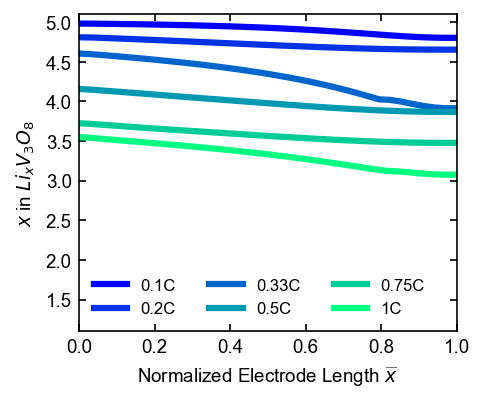

In [12]:
colors = plt.get_cmap('winter')(np.linspace(0,1,len(crates)))
linestyles = ['-','--',':']
labels = [r'$\widebar{x} = 0$',r'$\widebar{x} = 0.5$',r'$\widebar{x} = 1$']

fig,ax = plt.subplots()
for k,cr in enumerate(crates):
    filename = cwd+'/vary_crate/'+str(cr)+'_C/best_sim/Time_Voltage_Position.txt'
    TVPT = pd.read_csv(filename,delim_whitespace=True,skiprows=[1])
    TVPT = TVPT.loc[TVPT['Time'] == TVPT['Time'].unique()[1]]
    TVPT['c_ave'] = TVPT['Theta_Alpha']*TVPT['csa_NJc'] + TVPT['Theta_Beta']*TVPT['csb_NJc']
    ax.plot((TVPT['Position']-1)/np.max((TVPT['Position']-1)),1.1+TVPT['c_ave'],color=colors[k],label=str(cr)+'C')
    
ax.set_xlim(0,1)
ax.set_ylim(1.1,5.1)
ax.legend(frameon=False,fontsize=8,ncol=3,loc=3)
ax.set_xlabel(r'Normalized Electrode Length $\widebar{x}$')
ax.set_ylabel(r'$x$ in $Li_xV_3O_8$')

## Driving factors for sensitivity about optimum for each design parameter

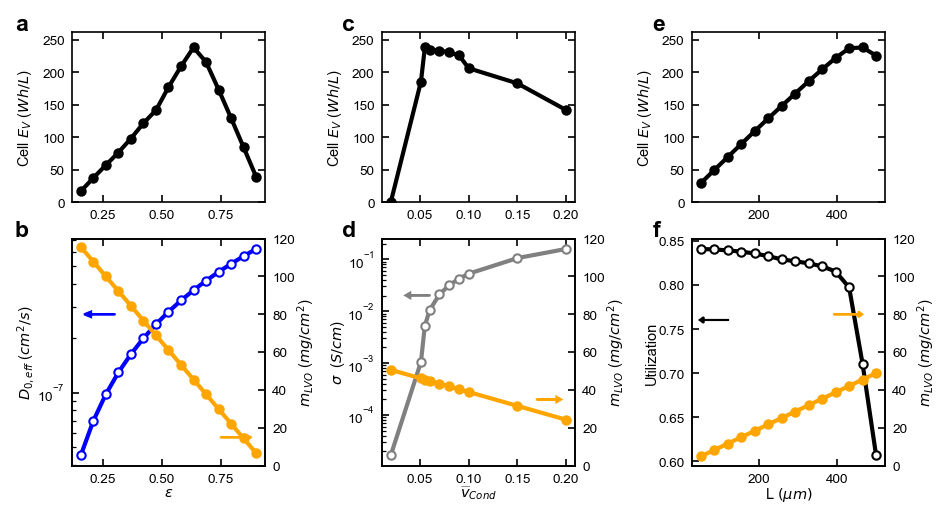

In [13]:
all_sims_that_ran = sims_dict['TB']
all_sims_that_ran = OHF.add_cell_ED_v2(all_sims_that_ran)
all_sims_that_ran,new_design_parameter = OHF.change_units(all_sims_that_ran,aed_col)

best_df = OHF.get_best_df(all_sims_that_ran,optimize_output=new_design_parameter)

cr = 0.33
best_df_cr_cut = best_df.loc[best_df['C-rate (1/h)']==cr]

fig = plt.figure(figsize=(6.5, 3.5)) 
gs = gridspec.GridSpec(2, 3, height_ratios=[1.5, 2]) 

label_fs=7
tick_fs = 6.5
ms=4
lw=2
lp=0
# Porosity
if True:
    porosity_cut = all_sims_that_ran.loc[all_sims_that_ran['C-rate (1/h)']==cr].copy()
    porosity_cut = porosity_cut.loc[porosity_cut['L (um)']==best_df_cr_cut['L (um)'].values[0]]
    porosity_cut = porosity_cut.loc[porosity_cut['Vol Frac Cond']==best_df_cr_cut['Vol Frac Cond'].values[0]]
    ax0 = plt.subplot(gs[0,0])
    ax = plt.subplot(gs[1,0],sharex=ax0)
    ax2 = ax.twinx()

    ax0.plot(porosity_cut['Porosity'],porosity_cut[new_design_parameter],'-ko',lw=lw,ms=ms)
    ax.semilogy(porosity_cut['Porosity'],1.33*0.55*(1e-6)*(porosity_cut['Porosity']**1.5),'bo-',lw=lw,ms=ms,mfc='white')
    ax2.plot(porosity_cut['Porosity'],porosity_cut['AM Areal Loading (mg/cm2)'],'-o',lw=lw,color='orange',ms=ms)
    ax.set_xlabel(r'$\epsilon$',fontsize=label_fs,labelpad=lp)
    ax.set_ylabel(r'$D_{0,eff}$ ($cm^2/s$)',fontsize=label_fs,labelpad=lp)
    ax2.set_ylabel(r'$m_{LVO}$ ($mg/cm^2$)',fontsize=label_fs,labelpad=lp)
    ax2.set_ylim(0,120)

    ax0.set_ylabel(r'Cell $E_V$ ($Wh/L$)',fontsize=label_fs)
    ax0.set_ylim(0,best_df_cr_cut[new_design_parameter].values[0]*1.1)

    ax2.arrow(0.75,15,0.1,0,color='orange',head_width=3, head_length=0.03)
    ax2.arrow(0.3,80,-0.1,0,color='blue',head_width=3, head_length=0.03)
    
    ax0.tick_params(labelsize=tick_fs)
    ax2.tick_params(labelsize=tick_fs)
    ax.tick_params(labelsize=tick_fs)
    
# Vol Frac Cond
if True:
    porosity_cut = all_sims_that_ran.loc[all_sims_that_ran['C-rate (1/h)']==cr]
    porosity_cut = porosity_cut.loc[porosity_cut['L (um)']==best_df_cr_cut['L (um)'].values[0]]
    porosity_cut = porosity_cut.loc[porosity_cut['Porosity']==best_df_cr_cut['Porosity'].values[0]]
    porosity_cut = porosity_cut.sort_values(by=['Vol Frac Cond'])
    porosity_cut = porosity_cut.loc[np.round(porosity_cut['Vol Frac Cond'],3)!=0.045]
    
    cond_list = []
    for vfc in porosity_cut['Vol Frac Cond'].values:
        cond_list.append(conductivity(vfc))
    porosity_cut['Conductivity (S/cm)'] = cond_list

    ax0 = plt.subplot(gs[0,1])
    ax = plt.subplot(gs[1,1],sharex=ax0)
    ax2 = ax.twinx()

    ax0.plot(porosity_cut['Vol Frac Cond'],porosity_cut[new_design_parameter],'-ko',lw=lw,ms=ms)
    ax.semilogy(porosity_cut['Vol Frac Cond'],porosity_cut['Conductivity (S/cm)'],'o-',color='grey',mfc='white',ms=ms,lw=lw)
    ax2.plot(porosity_cut['Vol Frac Cond'],porosity_cut['AM Areal Loading (mg/cm2)'],'-o',color='orange',ms=ms,lw=lw)
    ax.set_xlabel(r'$\widebar{v}_{Cond}$',fontsize=label_fs,labelpad=lp)
    ax.set_ylabel(r'$\sigma$  ($S/cm$)',fontsize=label_fs,labelpad=lp)
    ax2.set_ylabel(r'$m_{LVO}$ ($mg/cm^2$)',fontsize=label_fs,labelpad=lp)
    ax2.set_ylim(0,120)
    
    ax0.set_ylabel(r'Cell $E_V$ ($Wh/L$)',fontsize=label_fs)
    ax0.set_ylim(0,best_df_cr_cut[new_design_parameter].values[0]*1.1)

    ax2.arrow(0.17,35,0.02,0,color='orange',head_width=3, head_length=0.005)
    ax2.arrow(0.06,90,-0.02,0,color='grey',head_width=3, head_length=0.005)
    
    ax0.tick_params(labelsize=tick_fs)
    ax2.tick_params(labelsize=tick_fs)
    ax.tick_params(labelsize=tick_fs)
    
# L (um)
if True:
    porosity_cut = all_sims_that_ran.loc[all_sims_that_ran['C-rate (1/h)']==cr]
    porosity_cut = porosity_cut.loc[porosity_cut['Vol Frac Cond']==best_df_cr_cut['Vol Frac Cond'].values[0]]
    porosity_cut = porosity_cut.loc[porosity_cut['Porosity']==best_df_cr_cut['Porosity'].values[0]]
    
    
    ax0 = plt.subplot(gs[0,2])
    ax = plt.subplot(gs[1,2])
    ax2 = ax.twinx()
    
    ax0.plot(porosity_cut['L (um)'],porosity_cut[new_design_parameter],'-ko',lw=lw,ms=ms)
    ax.plot(porosity_cut['L (um)'],porosity_cut['Utilization'],'o-',color='black',ms=ms,mfc='white',lw=lw)
    ax2.plot(porosity_cut['L (um)'],porosity_cut['AM Areal Loading (mg/cm2)'],'-o',color='orange',ms=ms,lw=lw)
    ax.set_xlabel(r'L $(\mu m)$',fontsize=label_fs,labelpad=lp)
    ax.set_ylabel(r'Utilization',fontsize=label_fs,labelpad=lp)
    ax2.set_ylabel(r'$m_{LVO}$ ($mg/cm^2$)',fontsize=label_fs,labelpad=lp)
    ax2.set_ylim(0,120)

    ax0.set_ylabel(r'Cell $E_V$ ($Wh/L$)',fontsize=label_fs)
    ax0.set_ylim(0,best_df_cr_cut[new_design_parameter].values[0]*1.1)

    ax2.arrow(ax2.get_xlim()[1]*0.75,80,ax2.get_xlim()[1]*0.12,0,color='orange',head_width=3, head_length=10)
    ax2.arrow(ax2.get_xlim()[1]*0.23,77,-ax2.get_xlim()[1]*0.12,0,color='black',head_width=3, head_length=10)

    ax0.tick_params(labelsize=tick_fs)
    ax.tick_params(labelsize=tick_fs)
    ax2.tick_params(labelsize=tick_fs)
    
a = fig.axes
del a[1]
del a[3]
del a[5]

fig.tight_layout(h_pad=0.5,w_pad=0.5)
OHF.add_letters_v2(a,xmult=0.85,ymult=1.01,fontsize=11)

# Comparison of results for graphite anode vs Li metal anode

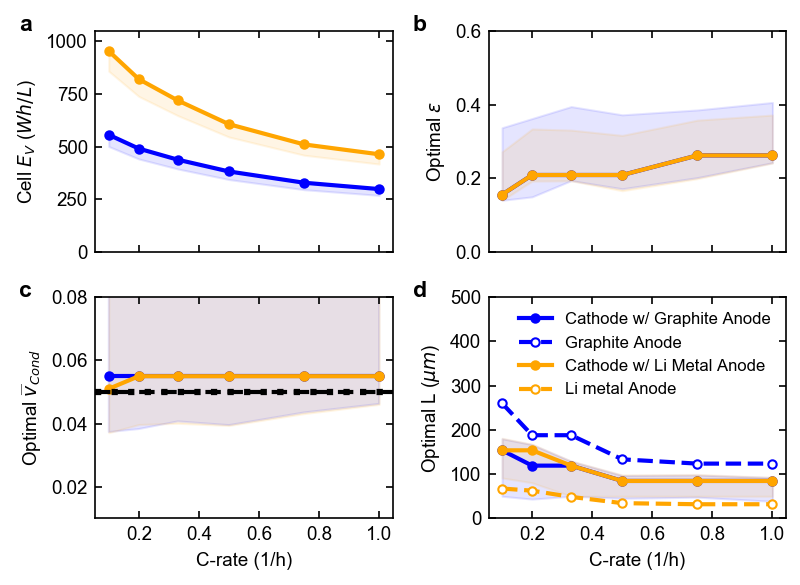

In [14]:
best_cols = ['Porosity','Vol Frac Cond','L (um)']
design_parameter = 'Cell Energy Density (Wh/cm3)'
LBOCs = [125]
colors = plt.get_cmap('hsv')(np.linspace(0.1,1,len(LBOCs)))

figi,axi = plt.subplots(2,2,figsize = (5.5,4),sharex=True, sharey=False)
all_sims_that_ran = sims_dict['TB'] 

all_sims_that_ran = OHF.add_cell_ED_v2(all_sims_that_ran)
all_sims_that_ran,new_design_parameter = OHF.change_units(all_sims_that_ran,design_parameter)
best_df2 = OHF.design_guide_plots(all_sims_that_ran,[new_design_parameter]+best_cols+['L_anode (um)'],[axi[0,0],axi[0,1],axi[1,0],axi[1,1],iax],optimize_output=new_design_parameter,color='blue',label=r'Graphite')
OHF.plot_percentile(all_sims_that_ran,best_cols,[axi[0,1],axi[1,0],axi[1,1],iax],color='blue',percentile=0.9,optimize_output=new_design_parameter)
axi[0,0].fill_between(crates,best_df2[new_design_parameter],(0.9)*best_df2[new_design_parameter],color='blue',label=None,alpha=0.1)

best_df = OHF.get_best_df(all_sims_that_ran,cols=[new_design_parameter]+best_cols+['L_anode (um)'],optimize_output=design_parameter)
axi[1,1].plot(best_df['C-rate (1/h)'],best_df['L_anode (um)'],'-o',linestyle='--',color='blue',lw=2,ms=4,mfc='white')

all_sims_that_ran = OHF.add_cell_ED_v3(all_sims_that_ran)
all_sims_that_ran,new_design_parameter = OHF.change_units(all_sims_that_ran,design_parameter)
best_df2 = OHF.design_guide_plots(all_sims_that_ran,[new_design_parameter]+best_cols+['L_anode (um)'],[axi[0,0],axi[0,1],axi[1,0],axi[1,1],iax],optimize_output=new_design_parameter,color='orange',label='Li Metal')
OHF.plot_percentile(all_sims_that_ran,best_cols,[axi[0,1],axi[1,0],axi[1,1],iax],color='orange',percentile=0.9,optimize_output=new_design_parameter)
axi[0,0].fill_between(crates,best_df2[new_design_parameter],(0.9)*best_df2[new_design_parameter],color='orange',label=None,alpha=0.1)

best_df2 = OHF.get_best_df(all_sims_that_ran,cols=[new_design_parameter]+best_cols+['L_anode (um)'],optimize_output=design_parameter)
axi[1,1].plot(best_df2['C-rate (1/h)'],best_df2['L_anode (um)'],'-o',linestyle='--',color='orange',lw=2,ms=4,mfc='white')

if True:
    axi[0,0].set_xlabel('')
    axi[0,0].set_ylabel(r'Cell $E_V$ ($Wh/L$)')#,color=colors[i])
    axi[0,0].set_ylim(0,best_df2.loc[0,new_design_parameter]*1.1)

    axi[0,1].set_ylim(0,0.6)
    axi[0,1].set_ylabel(r'Optimal $\epsilon$')
    axi[0,1].set_xlabel('')

    axi[1,0].set_yscale('log')
    axi[1,0].axhline(y=0.05,linestyle='--',color='black',lw=2)
    axi[1,0].set_yscale('linear')
    axi[1,0].set_ylim(0.01,0.08)
    axi[1,0].axhline(y=0.05,linestyle='dotted',color='black')
    axi[1,0].set_ylabel(r'Optimal $\widebar{v}_{Cond}$')

    axi[1,1].set_ylim(0,500)
    axi[1,1].set_ylabel(r'Optimal L ($\mu m$)')
    
    axi[1,1].legend(['Cathode w/ Graphite Anode','Graphite Anode','Cathode w/ Li Metal Anode','Li metal Anode'],fontsize=8)
    

figi.tight_layout()
OHF.add_letters_v2(figi.axes[:4],xmult=0.8,ymult=1.0,fontsize=11)

# Comparision of results by setting cutoff voltage to avoid phase change

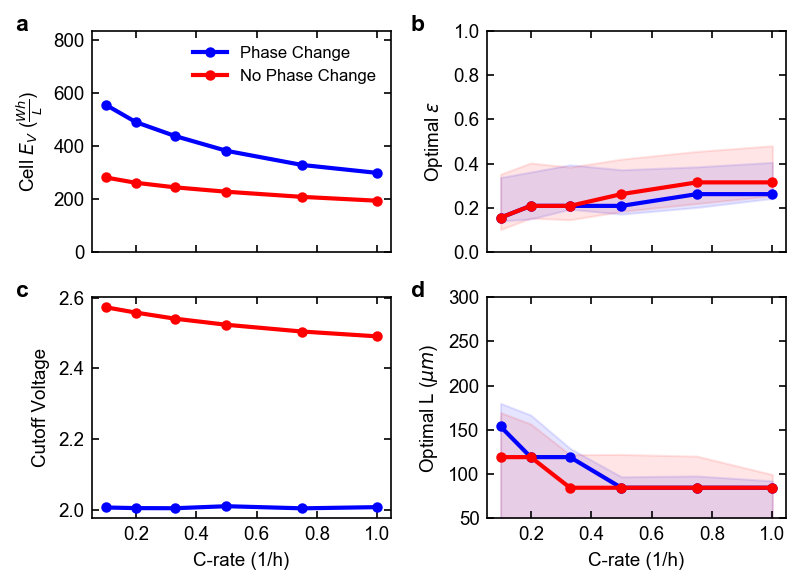

In [17]:
best_cols = list(['Porosity','Voltage','L (um)','Vol Frac Cond','Utilization'])
design_parameters = ['Cell Energy Density (Wh/cm3)']#,aed_col]#'Cell Power Density (W/cm3)',apd_col]
colors = [['blue','red'],['green','purple']]
output_labels = [r'Cell $E_V$ ($\frac{Wh}{L}$)',r'$E_A$ ($Wh/m^2$)']

fig3,ax3 = plt.subplots(2,2,figsize = (5.5,4),sharex=True, sharey=False)

noTBs = [False,True]

for j,(design_parameter,figi,axi) in enumerate(zip(design_parameters,[fig3],[ax3])):
       
    for k,tbtb in enumerate(['TB','noTB']):
        all_sims_that_ran = sims_dict[tbtb]
        all_sims_that_ran = all_sims_that_ran.loc[np.round(all_sims_that_ran['Vol Frac Cond'],3)==0.055]
        all_sims_that_ran = OHF.add_cell_ED_v2(all_sims_that_ran)        
        all_sims_that_ran,new_design_parameter = OHF.change_units(all_sims_that_ran,design_parameter)
        OHF.plot_percentile(all_sims_that_ran,best_cols[0:-2],[axi[0,1],axi[1,0],axi[1,1]],color=colors[j][k],percentile=0.9,optimize_output=new_design_parameter)
        best_df = OHF.design_guide_plots(all_sims_that_ran,[new_design_parameter]+best_cols,[axi[0,0],axi[0,1],axi[1,0],axi[1,1]],optimize_output=new_design_parameter,color=colors[j][k],noTB=noTBs[k])

        if k == 0:
            axi[0,0].set_ylim(0,best_df.loc[0,new_design_parameter]*1.5)
                 
    axi[0,0].set_xlabel('')
    axi[0,0].set_ylabel(output_labels[j])

    axi[0,1].set_ylim(0,1)
    axi[0,1].set_ylabel(r'Optimal $\epsilon$')
    axi[0,1].set_xlabel('')

    axi[1,1].set_ylim(50,300)
    axi[1,1].set_ylabel(r'Optimal L ($\mu m$)')
                
    axi[0,0].legend(['Phase Change','No Phase Change'],fontsize=8)
    
    axi[1,0].set_ylabel('Cutoff Voltage')

    figi.tight_layout()
    OHF.add_letters_v2(figi.axes[:4],xmult=0.8,ymult=1.0,fontsize=11)
#     figi.savefig('figures/avoid_phase_change_'+str(j)+'_box.png',transparent=True)


In [16]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')